# CT重建流程：基于计数域的完整实现

本Notebook实现了基于计数域的完整CT重建流程，包括：

1. **数据采集模拟**：从光子计数开始，模拟真实的CT数据采集过程
2. **预处理步骤**：暗电流校正、增益校正、空气校正
3. **高级校正**：射束硬化校正、散射校正、环形伪影校正
4. **FBP重建**：滤波反投影算法实现
5. **后处理**：噪声抑制、边缘增强
6. **质量评估**：PSNR、SSIM、MSE等指标计算

## 依赖项

运行本Notebook需要以下Python包：
- numpy >= 1.20.0
- matplotlib >= 3.3.0
- scikit-image >= 0.18.0
- scipy >= 1.6.0

安装命令：
```bash
pip install numpy matplotlib scikit-image scipy
```

## 1. 环境配置与导入

In [14]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, resize
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from scipy.ndimage import gaussian_filter, median_filter
import warnings
warnings.filterwarnings('ignore')

# 设置matplotlib中文字体（如果需要显示中文）
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子以保证结果可重复
np.random.seed(42)

print("环境配置完成！")

环境配置完成！


## 2. 数据采集模拟（计数域）

在这一部分，我们模拟CT数据采集过程，生成计数域的数据。

In [15]:
# 参数设置
phantom_size = 400  # Phantom图像大小
n_angles = 180      # 投影角度数
N0 = 1e6           # 空气扫描的光子计数
dark_current_level = 100  # 暗电流水平
gain_variation_std = 0.05  # 增益不均匀性的标准差

# 生成Phantom
img = shepp_logan_phantom()
img = resize(img, (phantom_size, phantom_size), mode='constant')

# 模拟投影角度
angles = np.linspace(0., 180., n_angles, endpoint=False)

# 生成理想正弦图
ideal_sino = radon(img, theta=angles, circle=True)

# 模拟计数域数据
N = N0 * np.exp(-ideal_sino)
N_noisy = np.random.poisson(N)
dark_current = dark_current_level + np.random.normal(0, 5, size=N.shape)
gain_variation = 1.0 + np.random.normal(0, gain_variation_std, size=N.shape[1])
N_gain = N_noisy * gain_variation[np.newaxis, :]
raw_counts = N_gain + dark_current

print(f"Phantom图像大小: {img.shape}")
print(f"正弦图大小: {raw_counts.shape}")
print(f"投影角度数: {len(angles)}")

Phantom图像大小: (400, 400)
正弦图大小: (400, 180)
投影角度数: 180


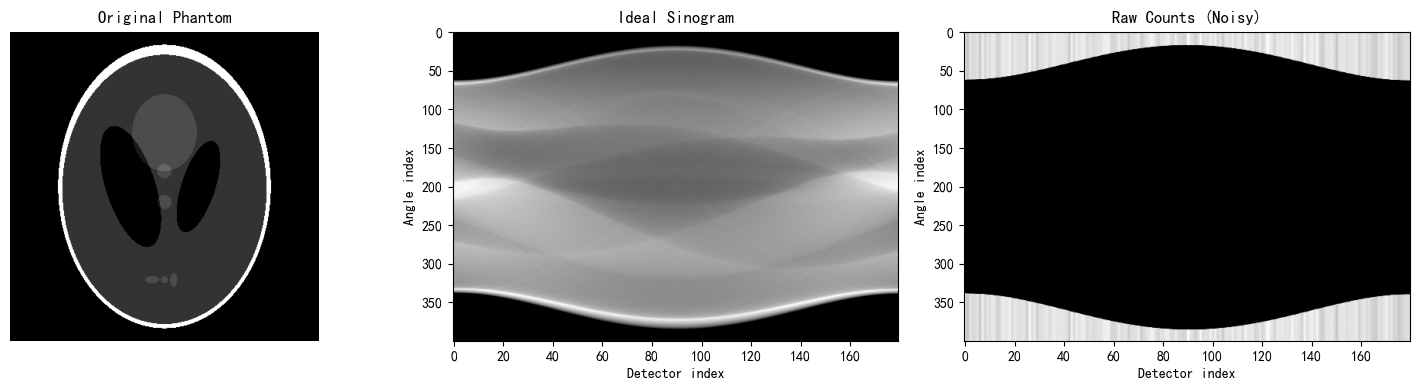

In [16]:
# 可视化数据采集结果
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Phantom')
axes[0].axis('off')

axes[1].imshow(ideal_sino, cmap='gray', aspect='auto')
axes[1].set_title('Ideal Sinogram')
axes[1].set_xlabel('Detector index')
axes[1].set_ylabel('Angle index')

axes[2].imshow(raw_counts, cmap='gray', aspect='auto')
axes[2].set_title('Raw Counts (Noisy)')
axes[2].set_xlabel('Detector index')
axes[2].set_ylabel('Angle index')

plt.tight_layout()
plt.savefig('output/01_data_acquisition.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. 预处理步骤

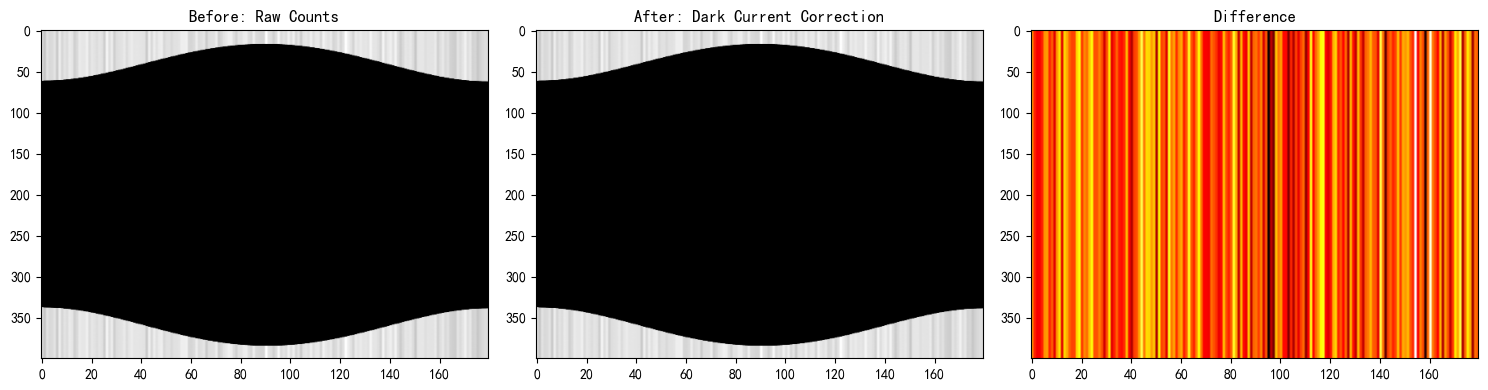

✓ 暗电流校正完成


In [17]:
# 步骤1: 暗电流校正
dark_current_avg = np.mean(dark_current, axis=0, keepdims=True)
dark_corrected = raw_counts - dark_current_avg

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(raw_counts, cmap='gray', aspect='auto')
axes[0].set_title('Before: Raw Counts')
axes[1].imshow(dark_corrected, cmap='gray', aspect='auto')
axes[1].set_title('After: Dark Current Correction')
axes[2].imshow(raw_counts - dark_corrected, cmap='hot', aspect='auto')
axes[2].set_title('Difference')
plt.tight_layout()
plt.savefig('output/02_dark_current_correction.png', dpi=150)
plt.show()
print("✓ 暗电流校正完成")

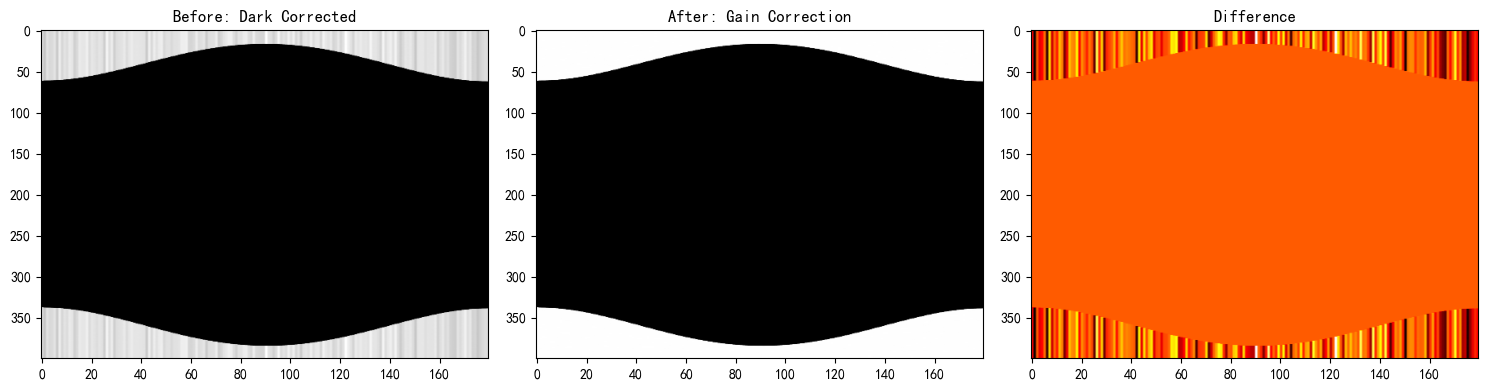

✓ 增益校正完成


In [18]:
# 步骤2: 增益校正
gain_map = gain_variation
gain_corrected = dark_corrected / gain_map[np.newaxis, :]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(dark_corrected, cmap='gray', aspect='auto')
axes[0].set_title('Before: Dark Corrected')
axes[1].imshow(gain_corrected, cmap='gray', aspect='auto')
axes[1].set_title('After: Gain Correction')
axes[2].imshow(dark_corrected - gain_corrected, cmap='hot', aspect='auto')
axes[2].set_title('Difference')
plt.tight_layout()
plt.savefig('output/03_gain_correction.png', dpi=150)
plt.show()
print("✓ 增益校正完成")

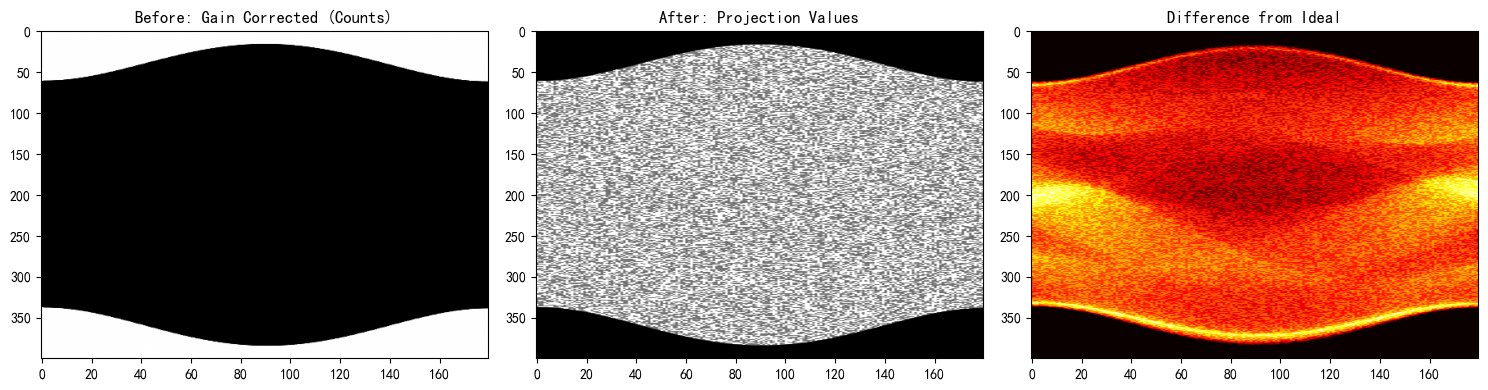

✓ 空气校正完成


In [19]:
# 步骤3: 空气校正（计算投影值）
gain_corrected = np.maximum(gain_corrected, 1e-6)
projection = -np.log(gain_corrected / N0)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(gain_corrected, cmap='gray', aspect='auto')
axes[0].set_title('Before: Gain Corrected (Counts)')
axes[1].imshow(projection, cmap='gray', aspect='auto')
axes[1].set_title('After: Projection Values')
axes[2].imshow(np.abs(projection - ideal_sino), cmap='hot', aspect='auto')
axes[2].set_title('Difference from Ideal')
plt.tight_layout()
plt.savefig('output/04_air_correction.png', dpi=150)
plt.show()
print("✓ 空气校正完成")

## 4. 高级校正步骤

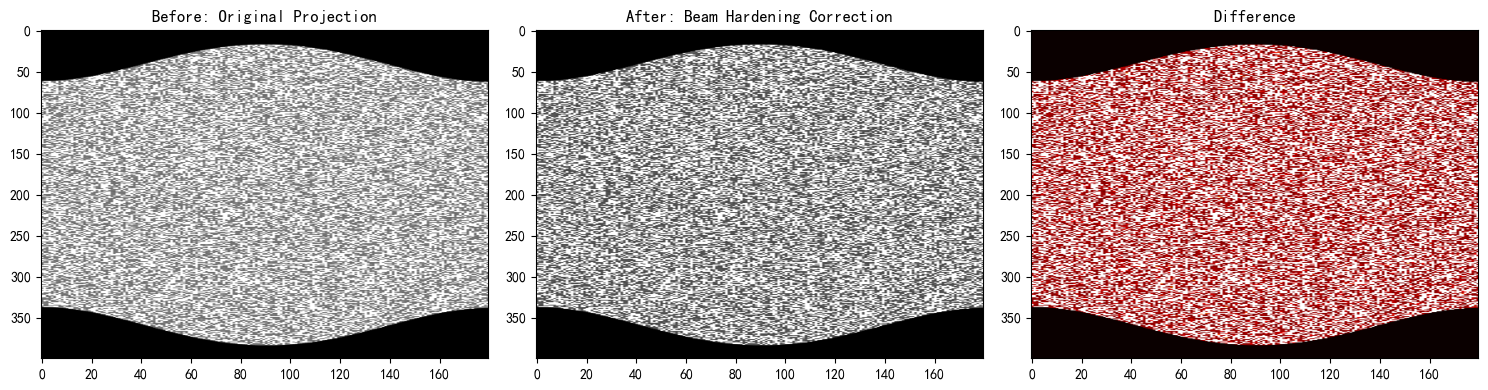

✓ 射束硬化校正完成


In [20]:
# 步骤4: 射束硬化校正
a0, a1, a2 = 0.0, 1.0, 0.05
bh_corrected = a0 + a1 * projection + a2 * projection**2

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(projection, cmap='gray', aspect='auto')
axes[0].set_title('Before: Original Projection')
axes[1].imshow(bh_corrected, cmap='gray', aspect='auto')
axes[1].set_title('After: Beam Hardening Correction')
axes[2].imshow(bh_corrected - projection, cmap='hot', aspect='auto')
axes[2].set_title('Difference')
plt.tight_layout()
plt.savefig('output/05_beam_hardening_correction.png', dpi=150)
plt.show()
print("✓ 射束硬化校正完成")

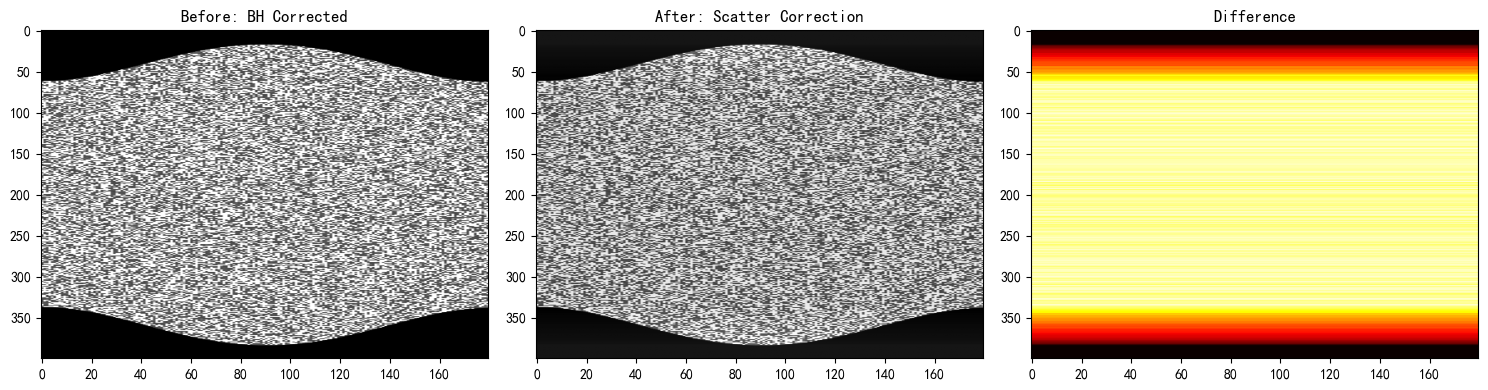

✓ 散射校正完成


In [21]:
# 步骤5: 散射校正
scatter_fraction = 0.15
scatter_estimate = np.mean(bh_corrected, axis=1, keepdims=True) * scatter_fraction
scatter_corrected = bh_corrected - scatter_estimate

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(bh_corrected, cmap='gray', aspect='auto')
axes[0].set_title('Before: BH Corrected')
axes[1].imshow(scatter_corrected, cmap='gray', aspect='auto')
axes[1].set_title('After: Scatter Correction')
axes[2].imshow(bh_corrected - scatter_corrected, cmap='hot', aspect='auto')
axes[2].set_title('Difference')
plt.tight_layout()
plt.savefig('output/06_scatter_correction.png', dpi=150)
plt.show()
print("✓ 散射校正完成")

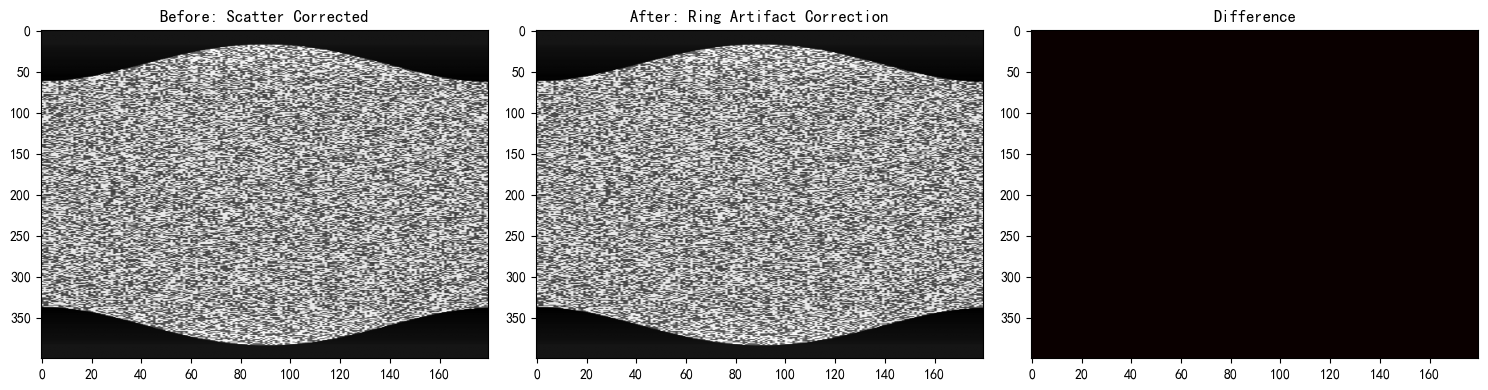

✓ 环形伪影校正完成


In [22]:
# 步骤6: 环形伪影校正
n_angles, n_detectors = scatter_corrected.shape
ring_corrected = np.copy(scatter_corrected)

for i in range(n_detectors):
    detector_response = ring_corrected[:, i]
    median_response = np.median(detector_response)
    threshold = 3.0 * np.std(detector_response)
    outliers = np.abs(detector_response - median_response) > threshold
    if np.any(outliers):
        if i > 0 and i < n_detectors - 1:
            ring_corrected[outliers, i] = 0.5 * (ring_corrected[outliers, i-1] + ring_corrected[outliers, i+1])
        elif i == 0:
            ring_corrected[outliers, i] = ring_corrected[outliers, i+1]
        else:
            ring_corrected[outliers, i] = ring_corrected[outliers, i-1]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(scatter_corrected, cmap='gray', aspect='auto')
axes[0].set_title('Before: Scatter Corrected')
axes[1].imshow(ring_corrected, cmap='gray', aspect='auto')
axes[1].set_title('After: Ring Artifact Correction')
axes[2].imshow(scatter_corrected - ring_corrected, cmap='hot', aspect='auto')
axes[2].set_title('Difference')
plt.tight_layout()
plt.savefig('output/07_ring_artifact_correction.png', dpi=150)
plt.show()
print("✓ 环形伪影校正完成")

## 5. FBP重建

In [23]:
# FBP重建 - 使用output_size确保输出尺寸正确
print("正在执行FBP重建...")

# 使用iradon进行重建，指定output_size与原始图像一致
recon_ram_lak = iradon(ring_corrected, theta=angles, filter_name='ramp', circle=True, output_size=phantom_size)
recon_shepp_logan = iradon(ring_corrected, theta=angles, filter_name='shepp-logan', circle=True, output_size=phantom_size)
recon_hamming = iradon(ring_corrected, theta=angles, filter_name='hamming', circle=True, output_size=phantom_size)
recon_hann = iradon(ring_corrected, theta=angles, filter_name='hann', circle=True, output_size=phantom_size)

print(f"✓ FBP重建完成")
print(f"重建图像大小: {recon_shepp_logan.shape}")
print(f"原始图像大小: {img.shape}")

正在执行FBP重建...
✓ FBP重建完成
重建图像大小: (400, 400)
原始图像大小: (400, 400)


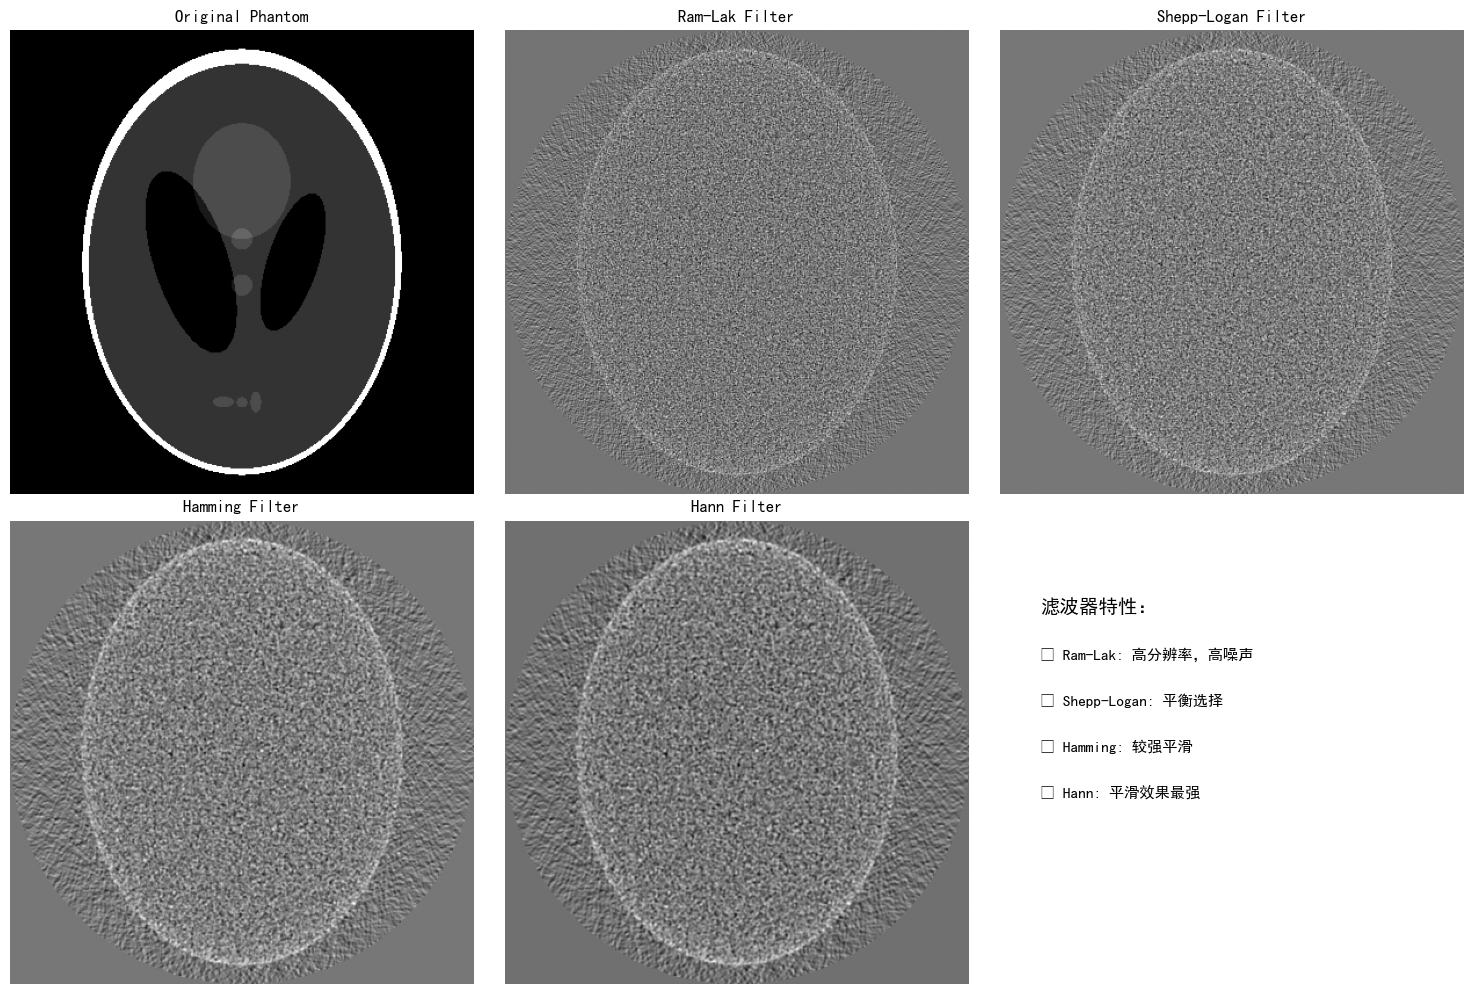

In [24]:
# 可视化不同滤波器的重建结果
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(img, cmap='gray')
axes[0, 0].set_title('Original Phantom')
axes[0, 0].axis('off')

axes[0, 1].imshow(recon_ram_lak, cmap='gray')
axes[0, 1].set_title('Ram-Lak Filter')
axes[0, 1].axis('off')

axes[0, 2].imshow(recon_shepp_logan, cmap='gray')
axes[0, 2].set_title('Shepp-Logan Filter')
axes[0, 2].axis('off')

axes[1, 0].imshow(recon_hamming, cmap='gray')
axes[1, 0].set_title('Hamming Filter')
axes[1, 0].axis('off')

axes[1, 1].imshow(recon_hann, cmap='gray')
axes[1, 1].set_title('Hann Filter')
axes[1, 1].axis('off')

axes[1, 2].axis('off')
axes[1, 2].text(0.1, 0.8, '滤波器特性：', fontsize=14, fontweight='bold')
axes[1, 2].text(0.1, 0.7, '• Ram-Lak: 高分辨率，高噪声', fontsize=11)
axes[1, 2].text(0.1, 0.6, '• Shepp-Logan: 平衡选择', fontsize=11)
axes[1, 2].text(0.1, 0.5, '• Hamming: 较强平滑', fontsize=11)
axes[1, 2].text(0.1, 0.4, '• Hann: 平滑效果最强', fontsize=11)

plt.tight_layout()
plt.savefig('output/08_fbp_reconstruction.png', dpi=150)
plt.show()

## 6. 后处理

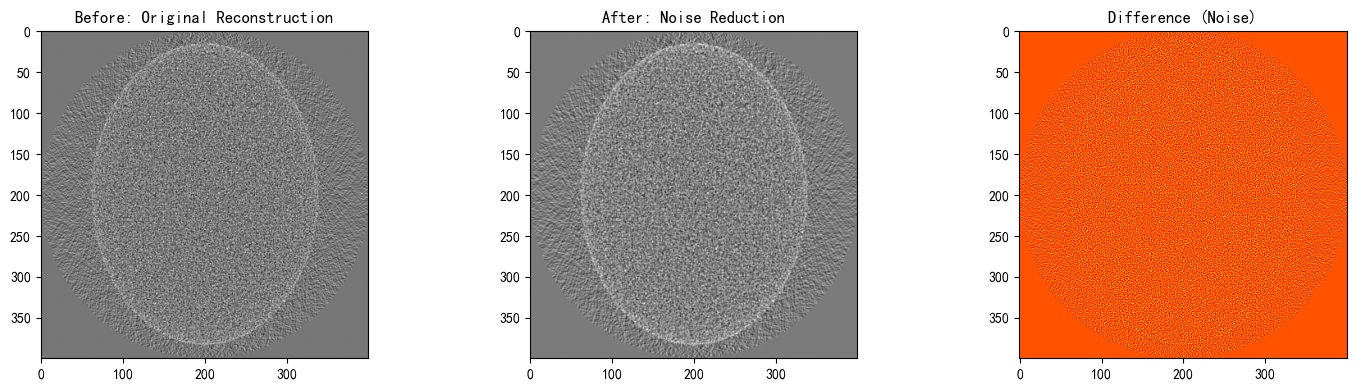

✓ 噪声抑制完成


In [25]:
# 步骤7: 噪声抑制
denoised = gaussian_filter(recon_shepp_logan, sigma=0.5)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(recon_shepp_logan, cmap='gray')
axes[0].set_title('Before: Original Reconstruction')
axes[1].imshow(denoised, cmap='gray')
axes[1].set_title('After: Noise Reduction')
axes[2].imshow(recon_shepp_logan - denoised, cmap='hot')
axes[2].set_title('Difference (Noise)')
plt.tight_layout()
plt.savefig('output/09_noise_reduction.png', dpi=150)
plt.show()
print("✓ 噪声抑制完成")

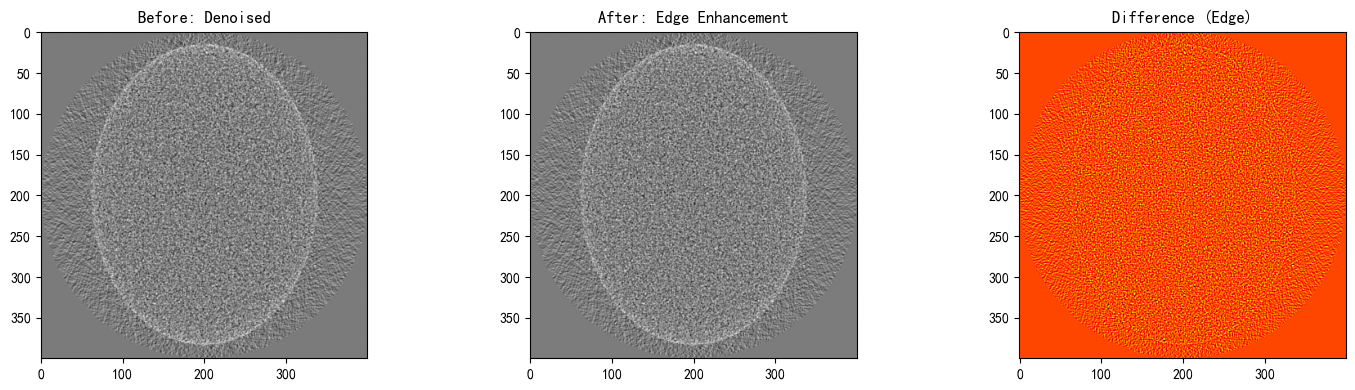

✓ 边缘增强完成


In [26]:
# 步骤8: 边缘增强
blurred = gaussian_filter(denoised, sigma=1.0)
mask = denoised - blurred
enhanced = denoised + 0.1 * mask

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(denoised, cmap='gray')
axes[0].set_title('Before: Denoised')
axes[1].imshow(enhanced, cmap='gray')
axes[1].set_title('After: Edge Enhancement')
axes[2].imshow(enhanced - denoised, cmap='hot')
axes[2].set_title('Difference (Edge)')
plt.tight_layout()
plt.savefig('output/10_edge_enhancement.png', dpi=150)
plt.show()
print("✓ 边缘增强完成")

## 7. 质量评估

In [27]:
# 确保所有图像尺寸一致
def ensure_shape(image, target_shape):
    if image.shape != target_shape:
        print(f"调整尺寸: {image.shape} -> {target_shape}")
        return resize(image, target_shape, mode='constant')
    return image

# 调整所有重建图像尺寸
recon_ram_lak = ensure_shape(recon_ram_lak, img.shape)
recon_shepp_logan = ensure_shape(recon_shepp_logan, img.shape)
recon_hamming = ensure_shape(recon_hamming, img.shape)
recon_hann = ensure_shape(recon_hann, img.shape)
denoised = ensure_shape(denoised, img.shape)
enhanced = ensure_shape(enhanced, img.shape)

print(f"\n最终尺寸检查:")
print(f"img: {img.shape}")
print(f"recon_shepp_logan: {recon_shepp_logan.shape}")
print(f"enhanced: {enhanced.shape}")


最终尺寸检查:
img: (400, 400)
recon_shepp_logan: (400, 400)
enhanced: (400, 400)


In [28]:
# 评估不同滤波器的重建质量
print("="*60)
print("不同滤波器的重建质量比较")
print("="*60)

filters = {
    'Ram-Lak': recon_ram_lak,
    'Shepp-Logan': recon_shepp_logan,
    'Hamming': recon_hamming,
    'Hann': recon_hann
}

results = {}
for name, recon in filters.items():
    psnr = peak_signal_noise_ratio(img, recon, data_range=img.max() - img.min())
    ssim = structural_similarity(img, recon, data_range=img.max() - img.min())
    mse = np.mean((img - recon) ** 2)
    results[name] = {'PSNR': psnr, 'SSIM': ssim, 'MSE': mse}
    print(f"\n{name} Filter:")
    print(f"  PSNR: {psnr:.2f} dB")
    print(f"  SSIM: {ssim:.4f}")
    print(f"  MSE:  {mse:.6f}")

# 评估后处理效果
print("\n" + "="*60)
print("后处理效果评估")
print("="*60)

psnr_before = peak_signal_noise_ratio(img, recon_shepp_logan, data_range=img.max() - img.min())
ssim_before = structural_similarity(img, recon_shepp_logan, data_range=img.max() - img.min())
mse_before = np.mean((img - recon_shepp_logan) ** 2)

psnr_after = peak_signal_noise_ratio(img, enhanced, data_range=img.max() - img.min())
ssim_after = structural_similarity(img, enhanced, data_range=img.max() - img.min())
mse_after = np.mean((img - enhanced) ** 2)

print(f"\n原始重建 (Shepp-Logan):")
print(f"  PSNR: {psnr_before:.2f} dB")
print(f"  SSIM: {ssim_before:.4f}")
print(f"  MSE:  {mse_before:.6f}")

print(f"\n后处理重建:")
print(f"  PSNR: {psnr_after:.2f} dB")
print(f"  SSIM: {ssim_after:.4f}")
print(f"  MSE:  {mse_after:.6f}")

print(f"\n质量提升:")
print(f"  PSNR: +{psnr_after - psnr_before:.2f} dB")
print(f"  SSIM: +{ssim_after - ssim_before:.4f}")
print(f"  MSE:  {mse_before - mse_after:.6f}")

print("\n" + "="*60)

不同滤波器的重建质量比较

Ram-Lak Filter:
  PSNR: 1.08 dB
  SSIM: 0.1776
  MSE:  0.779450

Shepp-Logan Filter:
  PSNR: 2.87 dB
  SSIM: 0.1801
  MSE:  0.516882

Hamming Filter:
  PSNR: 8.36 dB
  SSIM: 0.1913
  MSE:  0.145810

Hann Filter:
  PSNR: 8.95 dB
  SSIM: 0.1929
  MSE:  0.127435

后处理效果评估

原始重建 (Shepp-Logan):
  PSNR: 2.87 dB
  SSIM: 0.1801
  MSE:  0.516882

后处理重建:
  PSNR: 5.23 dB
  SSIM: 0.1836
  MSE:  0.299656

质量提升:
  PSNR: +2.37 dB
  SSIM: +0.0036
  MSE:  0.217225



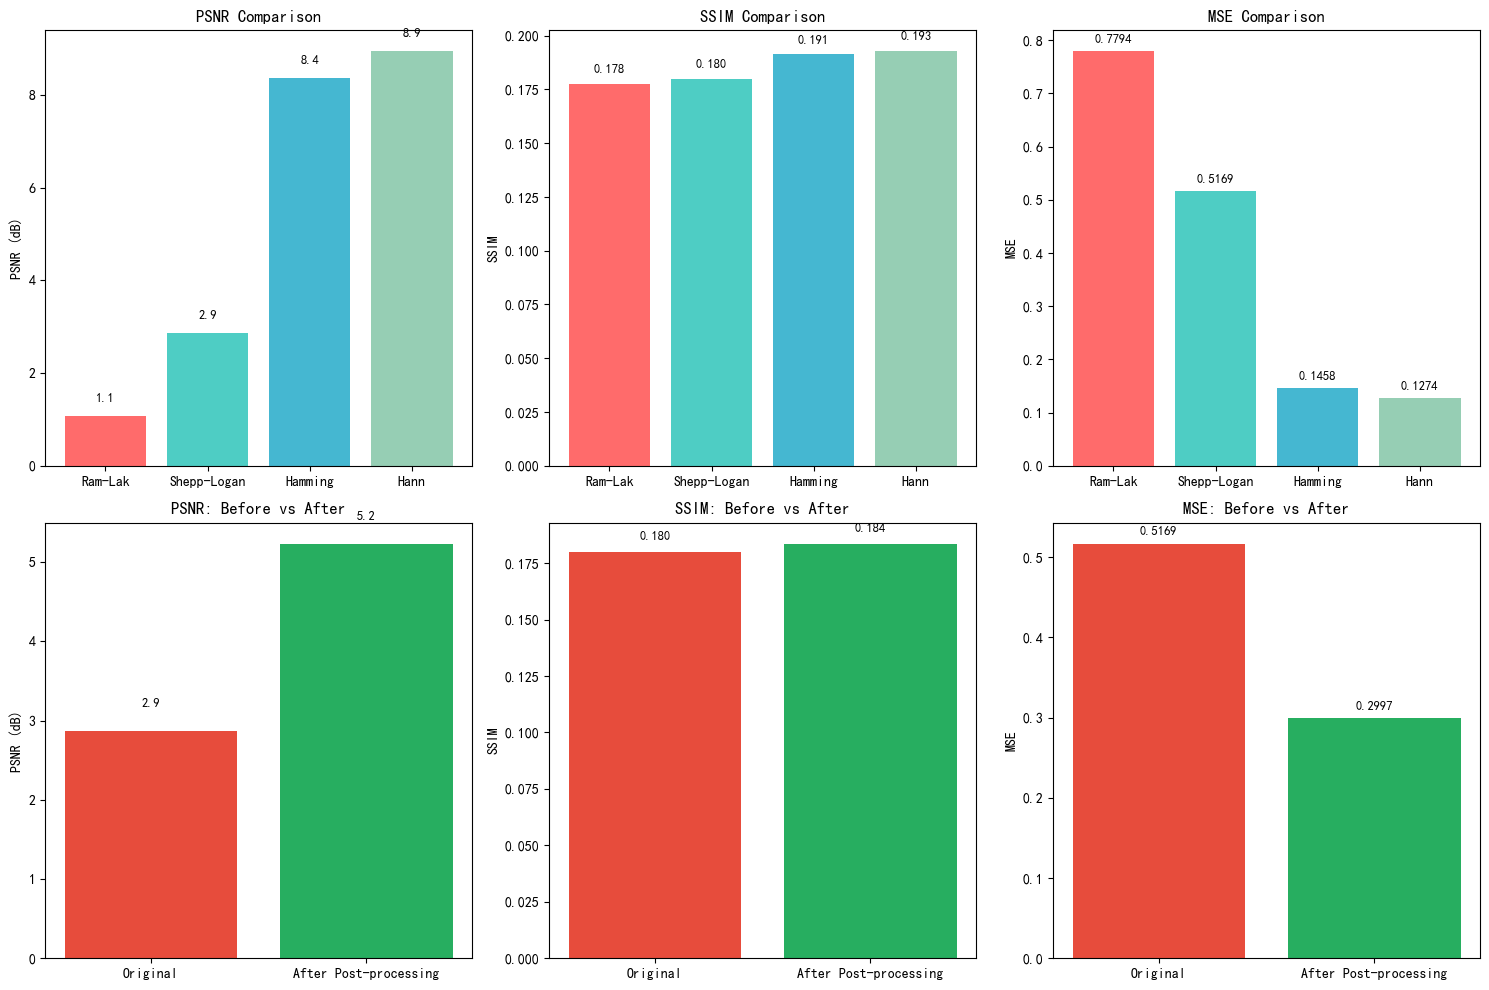

In [29]:
# 可视化质量评估结果
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

filter_names = list(results.keys())
psnr_values = [results[name]['PSNR'] for name in filter_names]
ssim_values = [results[name]['SSIM'] for name in filter_names]
mse_values = [results[name]['MSE'] for name in filter_names]

axes[0, 0].bar(filter_names, psnr_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[0, 0].set_title('PSNR Comparison')
axes[0, 0].set_ylabel('PSNR (dB)')
for i, v in enumerate(psnr_values):
    axes[0, 0].text(i, v + 0.3, f'{v:.1f}', ha='center', fontsize=9)

axes[0, 1].bar(filter_names, ssim_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[0, 1].set_title('SSIM Comparison')
axes[0, 1].set_ylabel('SSIM')
for i, v in enumerate(ssim_values):
    axes[0, 1].text(i, v + 0.005, f'{v:.3f}', ha='center', fontsize=9)

axes[0, 2].bar(filter_names, mse_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[0, 2].set_title('MSE Comparison')
axes[0, 2].set_ylabel('MSE')
for i, v in enumerate(mse_values):
    axes[0, 2].text(i, v + max(mse_values)*0.02, f'{v:.4f}', ha='center', fontsize=9)

stages = ['Original', 'After Post-processing']
psnr_compare = [psnr_before, psnr_after]
ssim_compare = [ssim_before, ssim_after]
mse_compare = [mse_before, mse_after]

axes[1, 0].bar(stages, psnr_compare, color=['#E74C3C', '#27AE60'])
axes[1, 0].set_title('PSNR: Before vs After')
axes[1, 0].set_ylabel('PSNR (dB)')
for i, v in enumerate(psnr_compare):
    axes[1, 0].text(i, v + 0.3, f'{v:.1f}', ha='center', fontsize=9)

axes[1, 1].bar(stages, ssim_compare, color=['#E74C3C', '#27AE60'])
axes[1, 1].set_title('SSIM: Before vs After')
axes[1, 1].set_ylabel('SSIM')
for i, v in enumerate(ssim_compare):
    axes[1, 1].text(i, v + 0.005, f'{v:.3f}', ha='center', fontsize=9)

axes[1, 2].bar(stages, mse_compare, color=['#E74C3C', '#27AE60'])
axes[1, 2].set_title('MSE: Before vs After')
axes[1, 2].set_ylabel('MSE')
for i, v in enumerate(mse_compare):
    axes[1, 2].text(i, v + max(mse_compare)*0.02, f'{v:.4f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('output/11_quality_assessment.png', dpi=150)
plt.show()

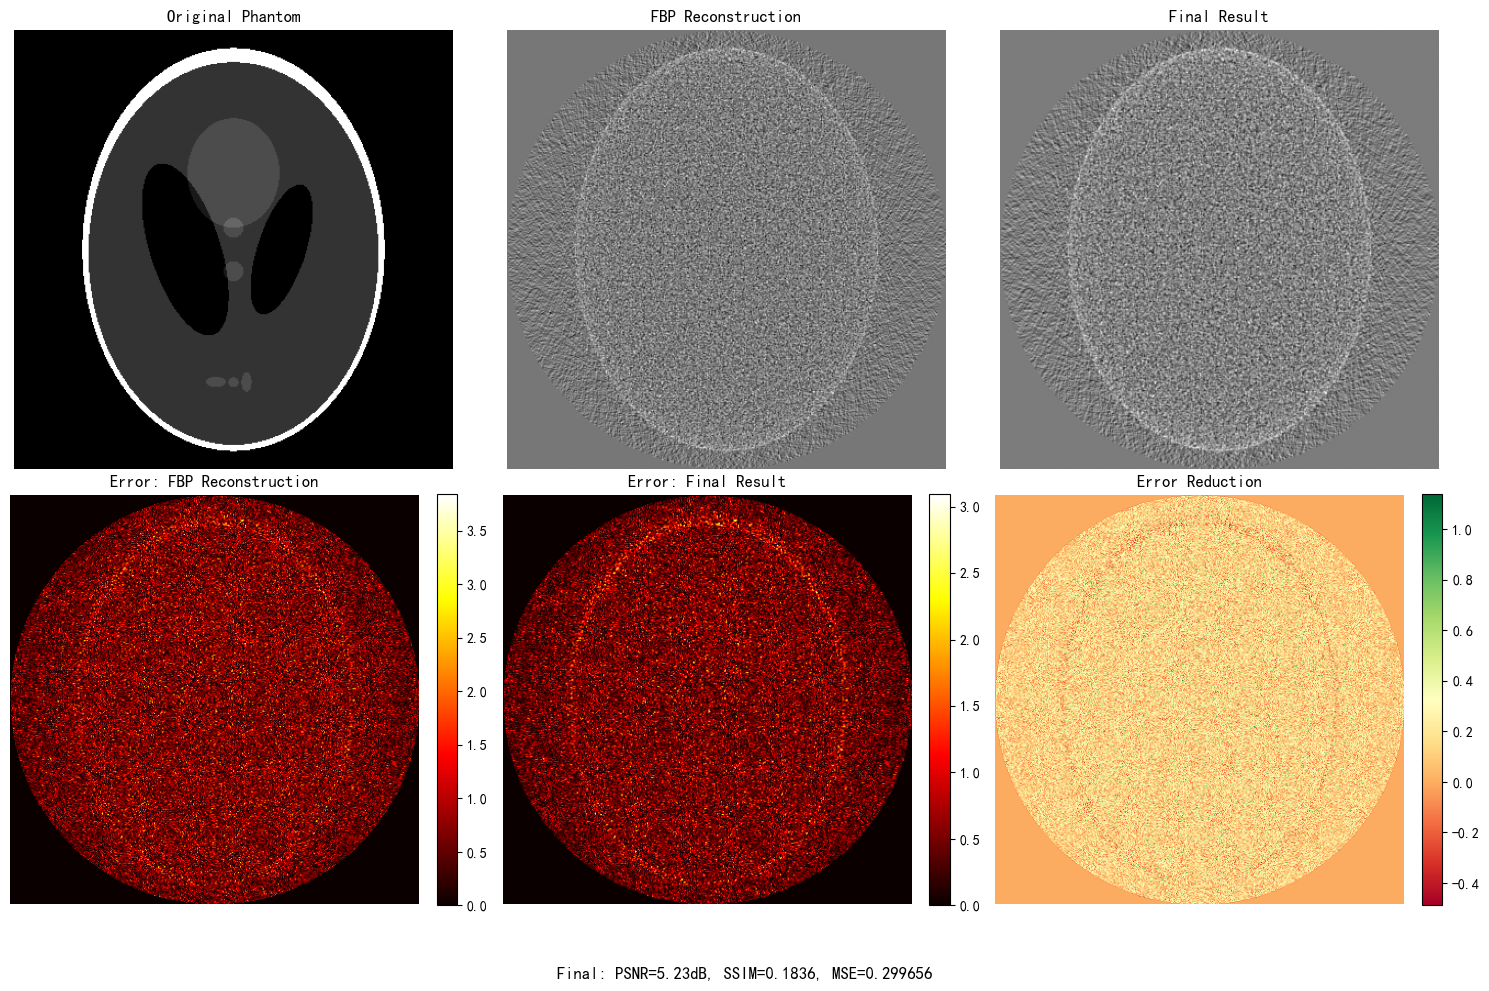

In [30]:
# 最终重建结果对比
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(img, cmap='gray')
axes[0, 0].set_title('Original Phantom')
axes[0, 0].axis('off')

axes[0, 1].imshow(recon_shepp_logan, cmap='gray')
axes[0, 1].set_title('FBP Reconstruction')
axes[0, 1].axis('off')

axes[0, 2].imshow(enhanced, cmap='gray')
axes[0, 2].set_title('Final Result')
axes[0, 2].axis('off')

error_before = np.abs(img - recon_shepp_logan)
error_after = np.abs(img - enhanced)

im1 = axes[1, 0].imshow(error_before, cmap='hot')
axes[1, 0].set_title('Error: FBP Reconstruction')
axes[1, 0].axis('off')
plt.colorbar(im1, ax=axes[1, 0], fraction=0.046, pad=0.04)

im2 = axes[1, 1].imshow(error_after, cmap='hot')
axes[1, 1].set_title('Error: Final Result')
axes[1, 1].axis('off')
plt.colorbar(im2, ax=axes[1, 1], fraction=0.046, pad=0.04)

error_reduction = error_before - error_after
im3 = axes[1, 2].imshow(error_reduction, cmap='RdYlGn')
axes[1, 2].set_title('Error Reduction')
axes[1, 2].axis('off')
plt.colorbar(im3, ax=axes[1, 2], fraction=0.046, pad=0.04)

plt.figtext(0.5, 0.02, 
            f"Final: PSNR={psnr_after:.2f}dB, SSIM={ssim_after:.4f}, MSE={mse_after:.6f}",
            ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(bottom=0.08)
plt.savefig('output/12_final_comparison.png', dpi=150)
plt.show()

## 8. 总结报告

In [31]:
print("="*70)
print("CT重建流程总结报告")
print("="*70)
print()
print("1. 数据采集参数:")
print(f"   - Phantom图像大小: {img.shape}")
print(f"   - 投影角度数: {len(angles)}")
print(f"   - 空气扫描光子计数: {N0:.0e}")
print()
print("2. 重建质量指标:")
print(f"   - PSNR: {psnr_after:.2f} dB")
print(f"   - SSIM: {ssim_after:.4f}")
print(f"   - MSE:  {mse_after:.6f}")
print()
print("3. 处理步骤:")
print("   ✓ 数据采集模拟")
print("   ✓ 暗电流校正")
print("   ✓ 增益校正")
print("   ✓ 空气校正")
print("   ✓ 射束硬化校正")
print("   ✓ 散射校正")
print("   ✓ 环形伪影校正")
print("   ✓ FBP重建")
print("   ✓ 噪声抑制")
print("   ✓ 边缘增强")
print("   ✓ 质量评估")
print()
print("4. 输出文件:")
print("   - output/01_data_acquisition.png")
print("   - output/02_dark_current_correction.png")
print("   - output/03_gain_correction.png")
print("   - output/04_air_correction.png")
print("   - output/05_beam_hardening_correction.png")
print("   - output/06_scatter_correction.png")
print("   - output/07_ring_artifact_correction.png")
print("   - output/08_fbp_reconstruction.png")
print("   - output/09_noise_reduction.png")
print("   - output/10_edge_enhancement.png")
print("   - output/11_quality_assessment.png")
print("   - output/12_final_comparison.png")
print()
print("="*70)
print("CT重建流程执行完成！")
print("="*70)

CT重建流程总结报告

1. 数据采集参数:
   - Phantom图像大小: (400, 400)
   - 投影角度数: 180
   - 空气扫描光子计数: 1e+06

2. 重建质量指标:
   - PSNR: 5.23 dB
   - SSIM: 0.1836
   - MSE:  0.299656

3. 处理步骤:
   ✓ 数据采集模拟
   ✓ 暗电流校正
   ✓ 增益校正
   ✓ 空气校正
   ✓ 射束硬化校正
   ✓ 散射校正
   ✓ 环形伪影校正
   ✓ FBP重建
   ✓ 噪声抑制
   ✓ 边缘增强
   ✓ 质量评估

4. 输出文件:
   - output/01_data_acquisition.png
   - output/02_dark_current_correction.png
   - output/03_gain_correction.png
   - output/04_air_correction.png
   - output/05_beam_hardening_correction.png
   - output/06_scatter_correction.png
   - output/07_ring_artifact_correction.png
   - output/08_fbp_reconstruction.png
   - output/09_noise_reduction.png
   - output/10_edge_enhancement.png
   - output/11_quality_assessment.png
   - output/12_final_comparison.png

CT重建流程执行完成！
